In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, AveragePooling2D, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import os
import cv2 as cv
import scipy as sp
import tensorflow as tf
import pickle
from tensorflow import keras

In [ ]:
group_classifier = keras.models.load_model("/content/drive/MyDrive/audio/models/level1.h5")
group1_classifier = keras.models.load_model("/content/drive/MyDrive/audio/models/de_fr_en_nl.h5")
group2_classifier = keras.models.load_model("/content/drive/MyDrive/audio/models/gr_es.h5")
group3_classifier = keras.models.load_model("/content/drive/MyDrive/audio/models/nv_sv.h5")
groups = [group1_classifier, group2_classifier, group3_classifier]

In [ ]:

#other,de,en,fr,nl
#other,el,es
#other,no,sv
with open('/content/drive/MyDrive/audio/augmented/de_augmented_npy', 'rb') as file:
    X = np.array(pickle.load(file)[:50])
    y = np.zeros(X.shape[0])
    size = X.shape[0]
with open('/content/drive/MyDrive/audio/augmented/fr_augmented_npy', 'rb') as file:
    X = np.append(X, pickle.load(file)[:50], axis=0)
    y = np.append(y, np.full(size, 2))

with open('/content/drive/MyDrive/audio/augmented/en_augmented_npy', 'rb') as file:
    X = np.append(X, pickle.load(file)[:50], axis=0)
    y = np.append(y, np.full(size, 1))

with open('/content/drive/MyDrive/audio/augmented/nl_augmented_npy', 'rb') as file:
    X = np.append(X, pickle.load(file)[:50], axis=0)
    y = np.append(y, np.full(size, 3))

with open('/content/drive/MyDrive/audio/augmented/el_augmented_npy', 'rb') as file:
    X = np.append(X, pickle.load(file)[:50], axis=0)
    y = np.append(y, np.full(size, 4))

with open('/content/drive/MyDrive/audio/augmented/es_augmented_npy', 'rb') as file:
    X = np.append(X, pickle.load(file)[:50], axis=0)
    y = np.append(y, np.full(size, 5))


with open('/content/drive/MyDrive/audio/augmented/no_augmented_npy', 'rb') as file:
    X = np.append(X, pickle.load(file)[:50], axis=0)
    y = np.append(y, np.full(size, 6))

with open('/content/drive/MyDrive/audio/augmented/sv_augmented_npy', 'rb') as file:
    X = np.append(X, pickle.load(file)[:50], axis=0)
    y = np.append(y, np.full(size, 7))

X = np.transpose(X,(0,3,1,2))

y = np.array(y)
print(X.shape)
print(y.shape)

(400, 5, 998, 40)
(400,)


In [ ]:
X = np.pad(X, [(0, ), (0, ), (1, ), (0, )], mode='constant')
print(X.shape)


(400, 5, 1000, 40)


In [ ]:
from sklearn.metrics import accuracy_score
predictions = []
for i in range(X.shape[0]):
  ini_data = X[i,0].reshape(1,1000,40,1)
  level1_ini = np.argmax(group_classifier.predict(ini_data,verbose=0))
  level2 = np.argmax(groups[level1_ini].predict(ini_data,verbose=0))

  if(level2 == 0):

    level1 = np.argmax(group_classifier.predict(X[i,1:].reshape(4,1000,40,1), verbose=0), axis=1)
    level1 = np.argmax(np.bincount(level1))

    level2 = []
    for j in range(1,5):
      level2.append(np.argmax(groups[level1].predict(X[i,j].reshape(1,1000,40,1),verbose=0), axis=1))

    level2 = np.array(level2).flatten()
    counts = np.bincount(level2)


    if(np.argmax(counts) == 0):
      if(len(counts) != 1):
        predictions.append(np.argmax(counts[1:]))
      else:
        predictions.append(10)
      continue

    if(level1_ini == 0):
      predictions.append(np.argmax(counts)-1)
    elif(level1_ini == 1):
      predictions.append(np.argmax(counts)+3)
    elif(level1_ini == 2):
      predictions.append(np.argmax(counts)+5)
  else:
    if(level1_ini == 0):
      predictions.append(level2-1) #de = 0, en = 1, fr = 2, nl = 3, level2[0]: de = 1, en = 2, fr = 3, nl = 4
    elif(level1_ini == 1):
      predictions.append(level2+3) #el = 4 , es = 5, level2[0]: el = 1 es = 2
    elif(level1_ini == 2):
      predictions.append(level2+5) #no = 6 , sv = 7, level2[0]: no = 1 sv = 2


predictions = np.array(predictions)
print(predictions.shape)

(400,)


In [ ]:
print(accuracy_score(y,predictions))

0.61


Text(141.0, 0.5, 'True')

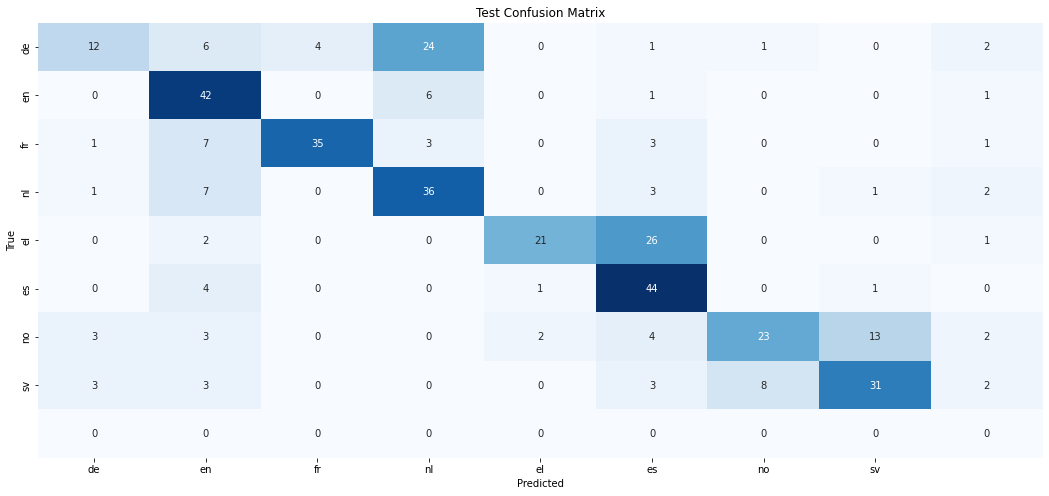

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_confu_matrix = confusion_matrix(y, predictions)
fault_type = ['de', 'en', 'fr', 'nl', 'el', 'es', 'no', 'sv']
plt.figure(1,figsize=(18,8))
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", cbar = False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')